# BL40A2020 Wireless Communication Systems

## Assignment  week 3: Digital modulation

## Author: Vili Raunola

### Follow the steps done in the [notes](https://github.com/pedrohjn/wireless-comm/blob/master/Week%203/week3.ipynb) to analyze the *[8PSK](https://komm.readthedocs.io/en/latest/komm.PSKModulation/)* modulation

**1. Signal constelation**

In [16]:
# Installing some libraries
! pip install scikit-dsp-comm
! pip install komm

In [17]:
# Same imports, styling and warning supression as in the example
import math
import komm
import sympy as sp
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

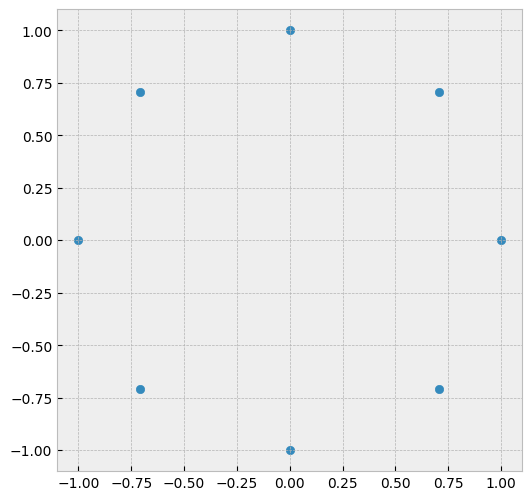

In [18]:
#8PSK
M = 8 # Order of the modulation
A = 1 # Base amplitude
T = np.pi/4 # Phase offset

psk = komm.PSKModulation(M, A, T)

plt.rcParams['figure.figsize'] = 6, 6
plt.scatter(psk.constellation.real,psk.constellation.imag)

**2. Numerical example:** Assume the following equation:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi 1000 t) - u_\mathrm{s}(t)\sin(2\pi 1000 t)$$

Plot the wave form for a random binary sequence of $12$ bits considering an information rate of 300 bits per second.

[0 1 0 1 0 1 1 1 0 1 0 0]


array([-1.00000000e+00+1.21168839e-16j,  7.07106781e-01-7.07106781e-01j,
       -7.07106781e-01+7.07106781e-01j, -4.26642159e-17+1.00000000e+00j])

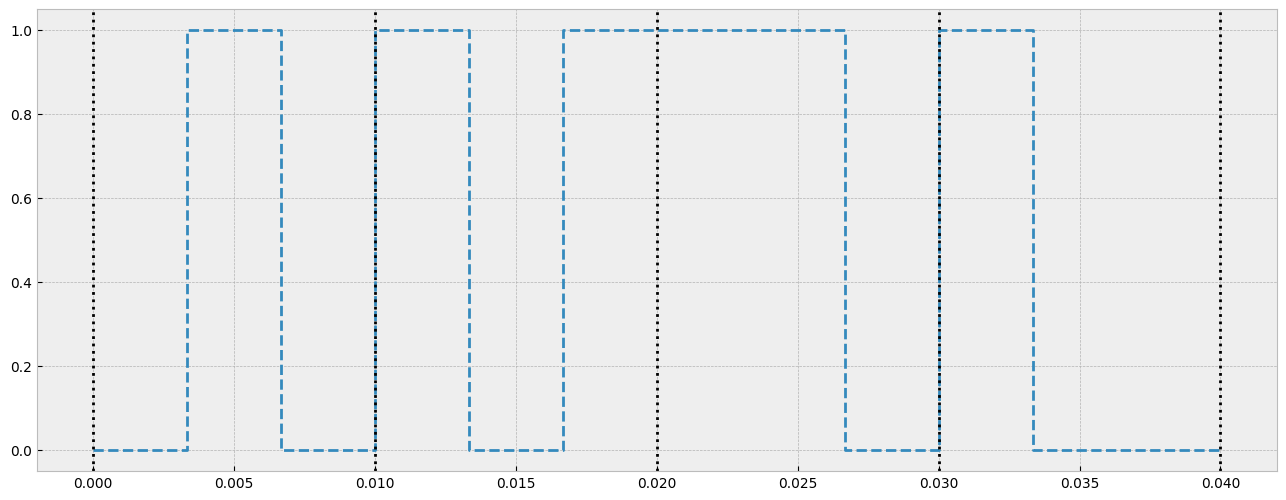

In [19]:
observations = 4
rate = 300


input_seq_size = observations * np.log2(M).astype(int)
binary_seq = np.random.randint(2, size=input_seq_size)
print(binary_seq)
tp = np.arange(0, input_seq_size, 1)/rate

# Plotting the binary sequence
plt.rcParams['figure.figsize'] = 16, 6
input_seq_plot = np.append(binary_seq,binary_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/rate)
plt.step(tp_plot,input_seq_plot,where='post',linestyle='--')
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k')

psk.modulate(binary_seq)


In [20]:
# Same code as in example. Separating the imaginary and real parts of the modulation
n_samples = 100
tmod_points = n_samples*input_seq_size
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
input_wave_aux = psk.modulate(binary_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)
for i in range(0,tmod_points):
    aux = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[aux],decimals=3) == np.around(psk.constellation[j],decimals=3): 
            input_wave_I[i] = psk.constellation[j].real 
            input_wave_Q[i] = psk.constellation[j].imag

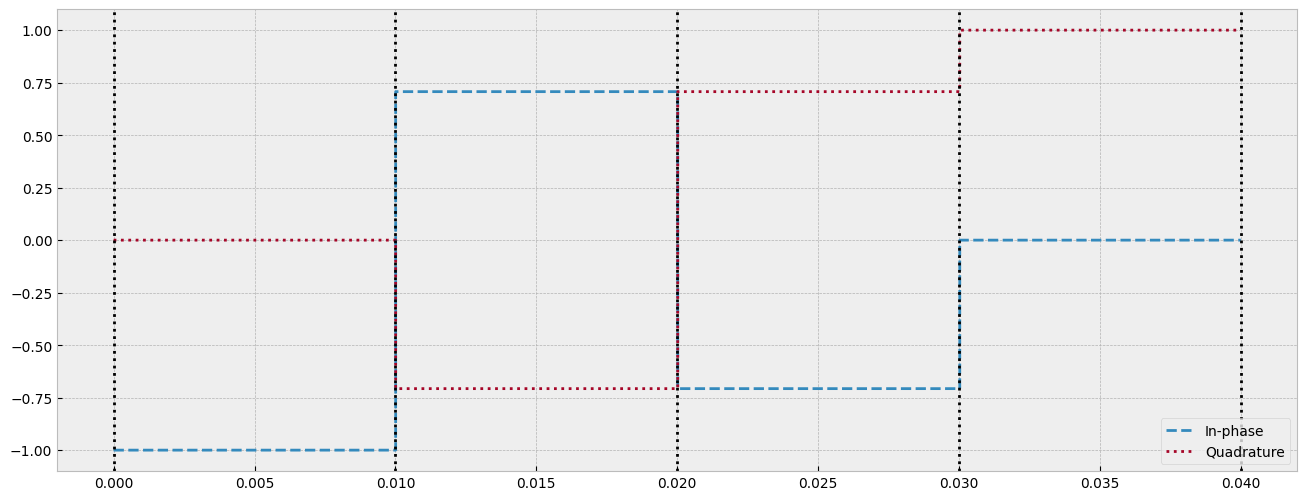

In [21]:
# Same code as in example. Plotting the inphase and quadrature component (real and imaginary parts)
plt.step(tmod,input_wave_I,where='post',linestyle='--',label='In-phase')
plt.step(tmod,input_wave_Q,where='post',linestyle=':',label='Quadrature')
plt.legend(loc='lower right')
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k')

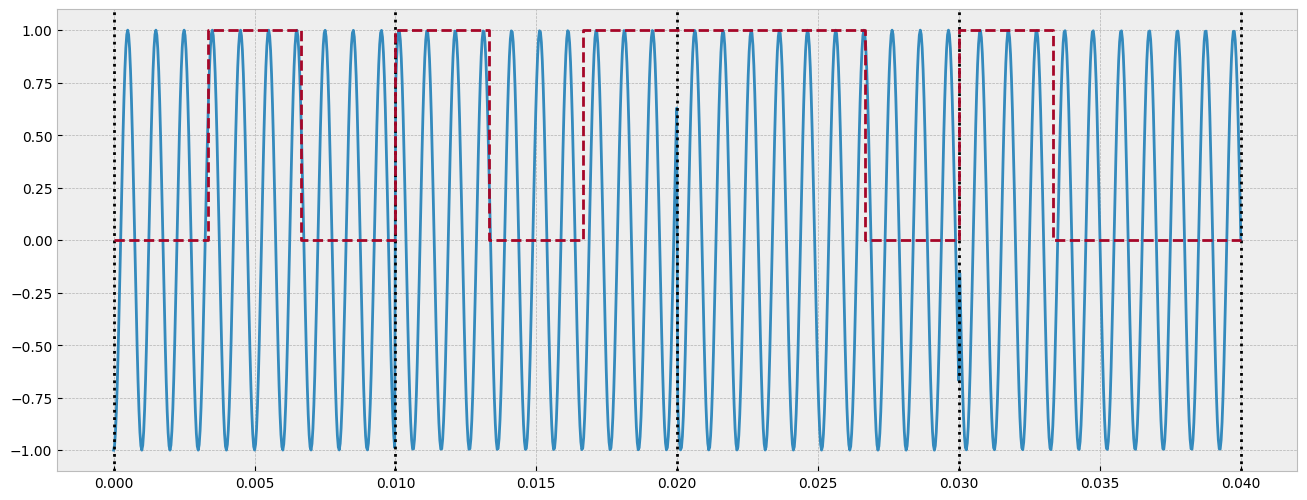

In [22]:
# Same code as in example
t = sp.symbols('t')

uc = sp.cos(2*sp.pi*1000*t)
us = sp.sin(2*sp.pi*1000*t)

modulation_I = sp.lambdify(t,uc,"numpy")
modulation_Q = sp.lambdify(t,us,"numpy")
plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k')
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')
plt.show()

**3. Compute analytically the 99% and 90% power-containment bandwidths and test it with numerical results**

B values from the book
- 3 bits per symbol at 300 bits per second --> 100 symbols per second = 1/T
- 90%, B = 0.85 -> B/T = 0.85 * 100 = 85Hz
- 99%, B = 10.2 -> B/T = 10.2 * 100 = 1020Hz

In [23]:
# Same code as in example. Creating the furier transformation of the signal's frequencies.
X = fftpack.fft(input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod)) / (tmod_points/tp_plot[input_seq_size])
freq = fftpack.fftfreq(len(input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))) * tmod_points/tp_plot[input_seq_size]
X = fftpack.fftshift(X)
freq = fftpack.fftshift(freq)
absX = np.abs(X) 

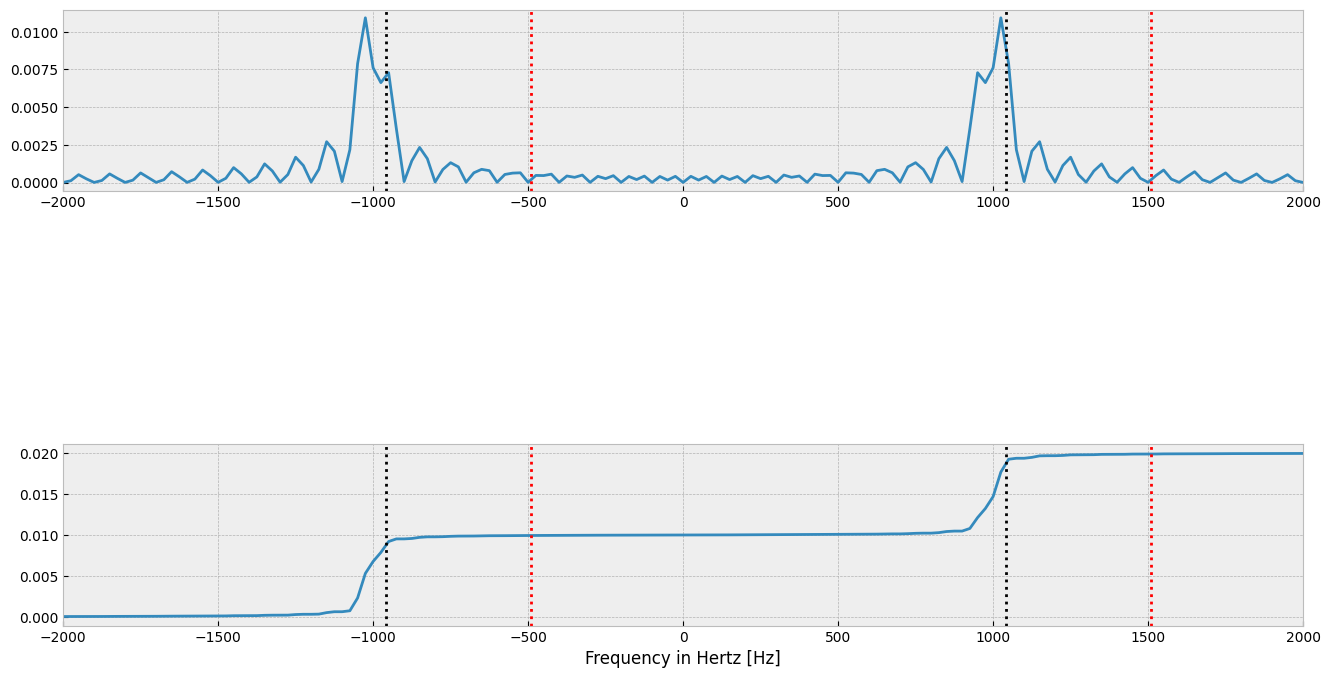

In [28]:
freq_c = 1000
# Same code as in example. Plotting the frequencies used and the cumulative sum 
plt.rcParams['figure.figsize'] = 16, 8
ax = plt.subplot(311)
ax.plot(freq,absX)
#ax.axvline(freq_c-85/2,linestyle=':',color='k')
ax.axvline(freq_c+85/2,linestyle=':',color='k')
#ax.axvline(freq_c-1020/2,linestyle=':',color='r')
ax.axvline(freq_c+1020/2,linestyle=':',color='r')
#ax.axvline(-freq_c-85/2,linestyle=':',color='k')
ax.axvline(-freq_c+85/2,linestyle=':',color='k')
#ax.axvline(-freq_c-1020/2,linestyle=':',color='r')
ax.axvline(-freq_c+1020/2,linestyle=':',color='r')
ax.set_xlim(-2000, 2000)
ax2 = plt.subplot(313)
ax2.plot(freq,np.cumsum(absX**2 /tp_plot[input_seq_size]))
#ax2.axvline(freq_c-85/2,linestyle=':',color='k')
ax2.axvline(freq_c+85/2,linestyle=':',color='k')
#ax2.axvline(freq_c-1020/2,linestyle=':',color='r')
ax2.axvline(freq_c+1020/2,linestyle=':',color='r')
#ax2.axvline(-freq_c-85/2,linestyle=':',color='k')
ax2.axvline(-freq_c+85/2,linestyle=':',color='k')
#ax2.axvline(-freq_c-1020/2,linestyle=':',color='r')
ax2.axvline(-freq_c+1020/2,linestyle=':',color='r')
ax2.set_xlabel('Frequency in Hertz [Hz]')
ax2.set_xlim(-2000, 2000)

From the graphs it can be seen that the black line represent the 90% mark and the red line the 99% mark which corresponds with the original calculations quite well.